In [1]:
import os 
import numpy as np
import cv2 as cv
import re

In [2]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Rotten or Fresh/dataset/'

In [3]:
classes = {'freshapples':0, 'freshbanana':1, 'freshoranges':2, 'rottenapples':3, 'rottenbanana':4, 'rottenoranges':5}

In [4]:
images = []
labels = []

def load_data(path):

    for folder in os.listdir(path):
        for folders in os.listdir(path + folder + '/'):
            for files in os.listdir(path  + folder + '/' + folders + '/'):
                label = classes[folders]
                image = cv.imread(path + folder + '/' + folders + '/' + files)
                if image is None:
                    continue
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (150, 150))
                image = image.astype('float32')/255.0
                images.append(image)
                labels.append(label)
    images_r = np.array(images)
    labels_r = np.array(labels)
    return images_r, labels_r

In [5]:
images, labels = load_data(path)

In [6]:
images.shape, labels.shape

((13599, 150, 150, 3), (13599,))

0


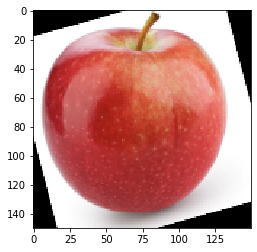

In [7]:
import matplotlib.pyplot as plt

print(labels[0])
plt.imshow(images[0])


4


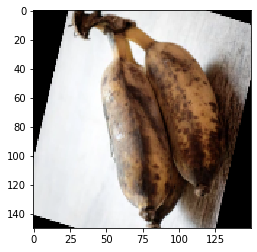

In [8]:
print(labels[2000])
plt.imshow(images[2000])

0


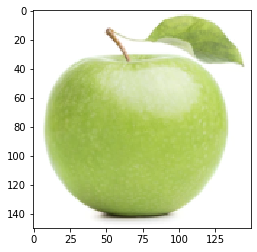

In [9]:
print(labels[4000])
plt.imshow(images[4000])

2


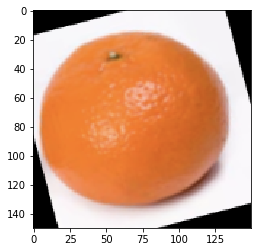

In [10]:
print(labels[6000])
plt.imshow(images[6000])

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.1, random_state=10)

In [13]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(12239, 150, 150, 3) (1360, 150, 150, 3) (12239, 6) (1360, 6)


In [14]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentor = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.05)

# train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
# val_batches = augmentor.flow(X_train, Y_train_req, subset='validation')

In [15]:
del images
del labels

In [16]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
def conv_layer(inputs, filters, stride):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(stride,stride), kernel_initializer='he_normal')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), padding='same', kernel_initializer='he_normal')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    shortcut = Conv2D(f3, (1,1), strides=(stride, stride), kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization(axis=3)(shortcut)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [18]:
def identity_layer(inputs, filters):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(1,1), padding='same', kernel_initializer='he_normal')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), padding='same', kernel_initializer='he_normal')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [19]:
def ResNet50(input_shape, classes):
    
    inputs = Input(input_shape)
    
    zero_padding = ZeroPadding2D((3,3))(inputs)
    
    #### CONVOLUTION BLOCK 1
    conv_1 = Conv2D(64, (7,7), strides=(2,2), kernel_initializer='he_normal')(zero_padding)
    conv_1 = BatchNormalization(axis=3)(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = ZeroPadding2D((1,1))(conv_1)
    conv_1 = MaxPooling2D((3,3), strides=(2,2))(conv_1)
    
    #### CONVOLUTIONAL BLOCK 2
    conv_2 = conv_layer(conv_1, [64, 64, 256], stride=1)
    conv_2 = identity_layer(conv_2, [64,64,256])
    conv_2 = identity_layer(conv_2, [64, 64, 256])
    
    #### CONVOLUTIONAL BLOCK 3
    conv_3 = conv_layer(conv_2, [128, 128, 512], stride=2)
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    
    #### CONVOLUTIONAL BLOCK 4
    conv_4 = conv_layer(conv_3, [256, 256, 1024], stride=2)
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    
    #### CONVOLUTIONAL BLOCK 5
    conv_5 = conv_layer(conv_4, [512, 512, 2048], stride=2)
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
   
    #### AVERAGE POOLING
    avg_pooling = GlobalAveragePooling2D()(conv_5)
    
    output = Dense(classes, activation='softmax')(avg_pooling)
    
    model_resnet50 = Model(inputs=inputs, outputs=output)
    
    return model_resnet50

In [20]:
model = ResNet50(input_shape=(150,150,3), classes=6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 75, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint(save_best_only=True, monitor='val_accuracy', patience=15, mode='max', filepath='E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Rotten or Fresh/Rotten_or_Fresh.h5')
# es = EarlyStopping(patience=15, monitor='val_accuracy', mode='auto', restore_best_weights=True)

In [23]:
history = model.fit(X_train, Y_train_req, epochs=50, validation_split=0.1, callbacks=[cp], batch_size=32)

Train on 11015 samples, validate on 1224 samples
Epoch 1/50
11015/11015 [==============================] - 200s 18ms/sample - loss: 0.6324 - accuracy: 0.8039 - val_loss: 0.3511 - val_accuracy: 0.8709
Epoch 2/50
11015/11015 [==============================] - 199s 18ms/sample - loss: 0.3419 - accuracy: 0.8843 - val_loss: 1.6844 - val_accuracy: 0.6626
Epoch 3/50
11015/11015 [==============================] - 216s 20ms/sample - loss: 0.2223 - accuracy: 0.9214 - val_loss: 0.8039 - val_accuracy: 0.7533
Epoch 4/50
11015/11015 [==============================] - 215s 19ms/sample - loss: 0.2492 - accuracy: 0.9150 - val_loss: 0.2867 - val_accuracy: 0.9077
Epoch 5/50
11015/11015 [==============================] - 210s 19ms/sample - loss: 0.2196 - accuracy: 0.9201 - val_loss: 1.0079 - val_accuracy: 0.7377
Epoch 6/50
11015/11015 [==============================] - 217s 20ms/sample - loss: 0.1407 - accuracy: 0.9493 - val_loss: 0.9550 - val_accuracy: 0.7565
Epoch 7/50
11015/11015 [=====================

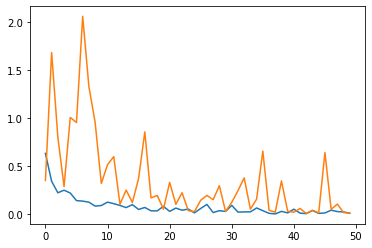

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

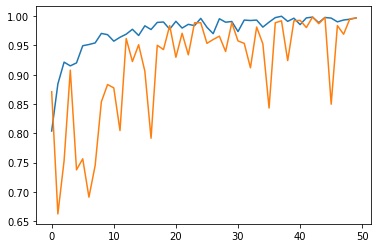

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [26]:
from tensorflow.keras.models import load_model

model_new = load_model('E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Rotten or Fresh/Rotten_or_Fresh.h5')

In [27]:
predictions = []

for i in range(len(X_test)):
    image = X_test[i].reshape((1, 150, 150, 3))
    predict = model_new.predict(image)
    i = np.argmax(predict)
    predictions.append(i)

In [28]:
predictions

[3,
 3,
 2,
 3,
 4,
 3,
 1,
 0,
 3,
 4,
 4,
 4,
 4,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 0,
 1,
 4,
 0,
 4,
 4,
 5,
 4,
 0,
 1,
 0,
 3,
 5,
 2,
 1,
 3,
 4,
 4,
 0,
 0,
 1,
 5,
 4,
 5,
 5,
 3,
 0,
 2,
 0,
 5,
 5,
 5,
 4,
 5,
 1,
 4,
 3,
 2,
 3,
 2,
 4,
 0,
 3,
 0,
 0,
 1,
 3,
 4,
 5,
 0,
 0,
 1,
 5,
 2,
 3,
 0,
 5,
 1,
 1,
 3,
 2,
 4,
 3,
 5,
 4,
 3,
 0,
 0,
 3,
 5,
 0,
 2,
 3,
 1,
 4,
 1,
 2,
 1,
 3,
 3,
 0,
 2,
 5,
 5,
 1,
 2,
 3,
 1,
 2,
 5,
 1,
 4,
 0,
 4,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 3,
 4,
 4,
 1,
 4,
 0,
 1,
 0,
 3,
 0,
 2,
 3,
 1,
 1,
 2,
 0,
 4,
 2,
 3,
 5,
 3,
 0,
 1,
 2,
 2,
 2,
 5,
 3,
 4,
 2,
 4,
 3,
 1,
 3,
 0,
 3,
 3,
 4,
 2,
 2,
 3,
 2,
 3,
 2,
 5,
 4,
 1,
 3,
 4,
 0,
 5,
 4,
 1,
 5,
 5,
 4,
 5,
 3,
 5,
 2,
 3,
 2,
 1,
 0,
 2,
 5,
 3,
 3,
 0,
 3,
 5,
 4,
 3,
 3,
 4,
 0,
 4,
 5,
 0,
 0,
 3,
 4,
 0,
 5,
 0,
 4,
 5,
 0,
 1,
 0,
 0,
 2,
 4,
 4,
 3,
 0,
 3,
 3,
 3,
 5,
 0,
 4,
 0,
 5,
 0,
 3,
 5,
 4,
 3,
 5,
 4,
 3,
 3,
 0,
 5,
 5,
 2,
 3,
 1,
 4,
 4,
 3,
 4,
 2,
 3,
 5,
 0,
 5,


0.9977941176470588


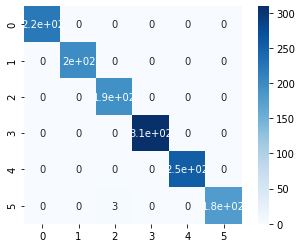

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

print(accuracy_score(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
hm = sns.heatmap(cm, annot=True, square=True, cmap='Blues')
plt.show()